In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datadir = "/content/drive/My Drive/CS445_project/"
training_directory = datadir + "raf_db/DATASET/train"
validation_directory = datadir + "raf_db/DATASET/test"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from keras.metrics import Precision, Recall
import cv2
import numpy as np

# Data Preprocessing

In [ ]:
target_image_size = 100
batch_size = 64

In [ ]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.5
)

In [ ]:
training_generator_rn = training_datagen.flow_from_directory(
    directory = training_directory,
    target_size = (target_image_size, target_image_size),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training",
    color_mode = "rgb"
)

validation_generator_rn = validation_datagen.flow_from_directory(
    directory = validation_directory,
    target_size = (target_image_size, target_image_size),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    color_mode = "rgb"
)

Found 12281 images belonging to 7 classes.
Found 1533 images belonging to 7 classes.


In [ ]:
training_generator_custom = training_datagen.flow_from_directory(
    directory = training_directory,
    target_size = (target_image_size, target_image_size),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training",
    color_mode = "rgb",
)

validation_generator_custom = validation_datagen.flow_from_directory(
    directory = validation_directory,
    target_size = (target_image_size, target_image_size),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    color_mode = "rgb",
)

Found 12281 images belonging to 7 classes.
Found 1533 images belonging to 7 classes.


# Modeling

Load pre-trained ResNet50 model

In [ ]:
from keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(target_image_size, target_image_size, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

Add more top layers

In [ ]:
model_rn = Sequential([
    base_model,
    Dropout(0.3),
    Flatten(),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

In [ ]:
model_rn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (Batch  (None, 32768)             131072    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

Define custom model

In [ ]:
model_custom = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(target_image_size,target_image_size,3)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:
model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 96, 96, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                      

In [ ]:
metrics = ['accuracy',
           Precision(),
           Recall()]

In [ ]:
model_rn.compile(optimizer = Adam(0.0001),
              loss = 'categorical_crossentropy',
              metrics = metrics)

In [ ]:
model_custom.compile(optimizer = Adam(0.0001),
              loss = 'categorical_crossentropy',
              metrics = metrics)

# Training

In [ ]:
history_rn = model_rn.fit(
    x = training_generator_rn,
    epochs = 30,
    steps_per_epoch = len(training_generator_rn),
    validation_data = validation_generator_rn,
    validation_steps = len(validation_generator_rn)
)

Epoch 1/30
192/192 [==============================] - 5246s 27s/step - loss: 2.1721 - accuracy: 0.2093 - precision: 0.2398 - recall: 0.0522 - val_loss: 2.1209 - val_accuracy: 0.1670 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
192/192 [==============================] - 97s 505ms/step - loss: 1.9570 - accuracy: 0.2824 - precision: 0.4121 - recall: 0.0796 - val_loss: 1.9622 - val_accuracy: 0.2740 - val_precision: 0.3831 - val_recall: 0.0385
Epoch 3/30
192/192 [==============================] - 89s 465ms/step - loss: 1.8151 - accuracy: 0.3430 - precision: 0.5312 - recall: 0.1109 - val_loss: 1.9390 - val_accuracy: 0.2414 - val_precision: 0.4286 - val_recall: 0.0196
Epoch 4/30
192/192 [==============================] - 92s 477ms/step - loss: 1.7411 - accuracy: 0.3808 - precision: 0.5824 - recall: 0.1467 - val_loss: 1.8818 - val_accuracy: 0.3581 - val_precision: 0.4596 - val_recall: 0.0483
Epoch 5/30
192/192 [==============================] - 92s 482ms/step - loss: 1.6843 

In [ ]:
history_custom = model_custom.fit(
    x = training_generator_custom,
    epochs = 50,
    steps_per_epoch = len(training_generator_custom),
    validation_data = validation_generator_custom,
    validation_steps = len(validation_generator_custom)
)

Epoch 1/50
192/192 [==============================] - 99s 475ms/step - loss: 2.6055 - accuracy: 0.2436 - precision: 0.3210 - recall: 0.1677 - val_loss: 2.1802 - val_accuracy: 0.3862 - val_precision: 0.3858 - val_recall: 0.3855
Epoch 2/50
192/192 [==============================] - 90s 471ms/step - loss: 2.2022 - accuracy: 0.3215 - precision: 0.3899 - recall: 0.2016 - val_loss: 2.8304 - val_accuracy: 0.3894 - val_precision: 0.3972 - val_recall: 0.3731
Epoch 3/50
192/192 [==============================] - 89s 463ms/step - loss: 2.0114 - accuracy: 0.3687 - precision: 0.4676 - recall: 0.2468 - val_loss: 2.2629 - val_accuracy: 0.4377 - val_precision: 0.4815 - val_recall: 0.3907
Epoch 4/50
192/192 [==============================] - 89s 461ms/step - loss: 1.8294 - accuracy: 0.4128 - precision: 0.5244 - recall: 0.2889 - val_loss: 1.8186 - val_accuracy: 0.4892 - val_precision: 0.5400 - val_recall: 0.4097
Epoch 5/50
192/192 [==============================] - 94s 490ms/step - loss: 1.7414 - accura

In [ ]:
model_rn.save('model_rn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_custom.save('model_custom.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

In [ ]:
import matplotlib.pyplot as plt


def evaluate(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_precision = history.history['precision']
    val_precision = history.history['val_precision']
    train_recall = history.history['recall']
    val_recall = history.history['val_recall']

    fig, ax = plt.subplots(1, 4, figsize=(32, 6))

    # accuracy
    ax[0].plot(train_acc, label='Training Accuracy')
    ax[0].plot(val_acc, label='Validation Accuracy')
    ax[0].set_title('Training vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    # loss
    ax[1].plot(train_loss, label='Training Loss')
    ax[1].plot(val_loss, label='Validation Loss')
    ax[1].set_title('Training vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    # precision
    ax[2].plot(train_precision, label='Training Precision')
    ax[2].plot(val_precision, label='Validation Precision')
    ax[2].set_title('Training vs Validation Precision')
    ax[2].set_ylabel('Precision')
    ax[2].set_xlabel('Epoch')
    ax[2].legend()

    # recall
    ax[3].plot(train_recall, label='Training Recall')
    ax[3].plot(val_recall, label='Validation Recall')
    ax[3].set_title('Training vs Validation Recall')
    ax[3].set_ylabel('Recall')
    ax[3].set_xlabel('Epoch')
    ax[3].legend()

    plt.tight_layout()
    plt.show()

Results for model with ResNet50

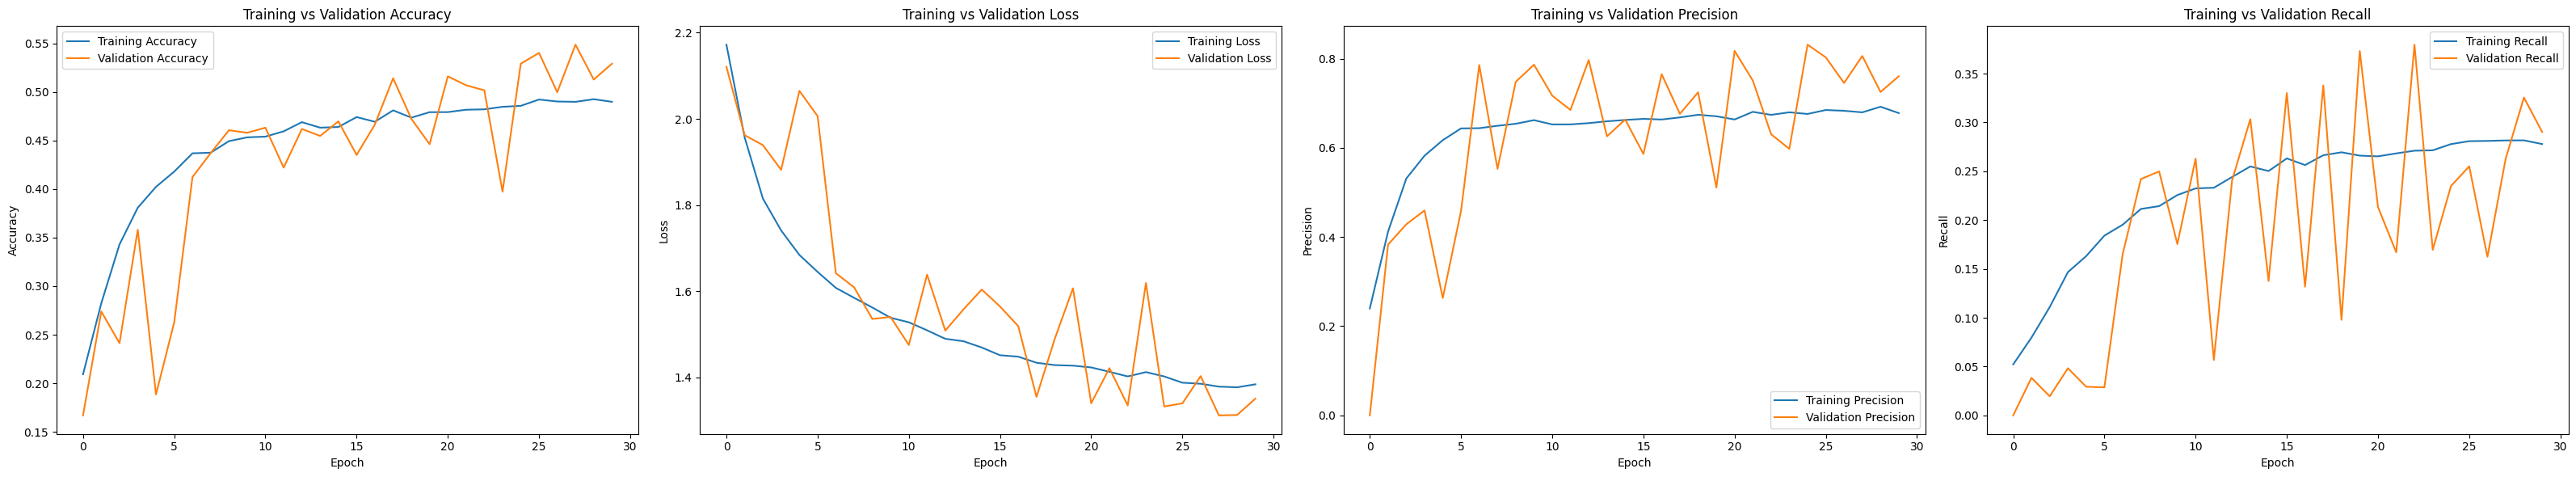

In [ ]:
evaluate(history_rn)

Results for custom model

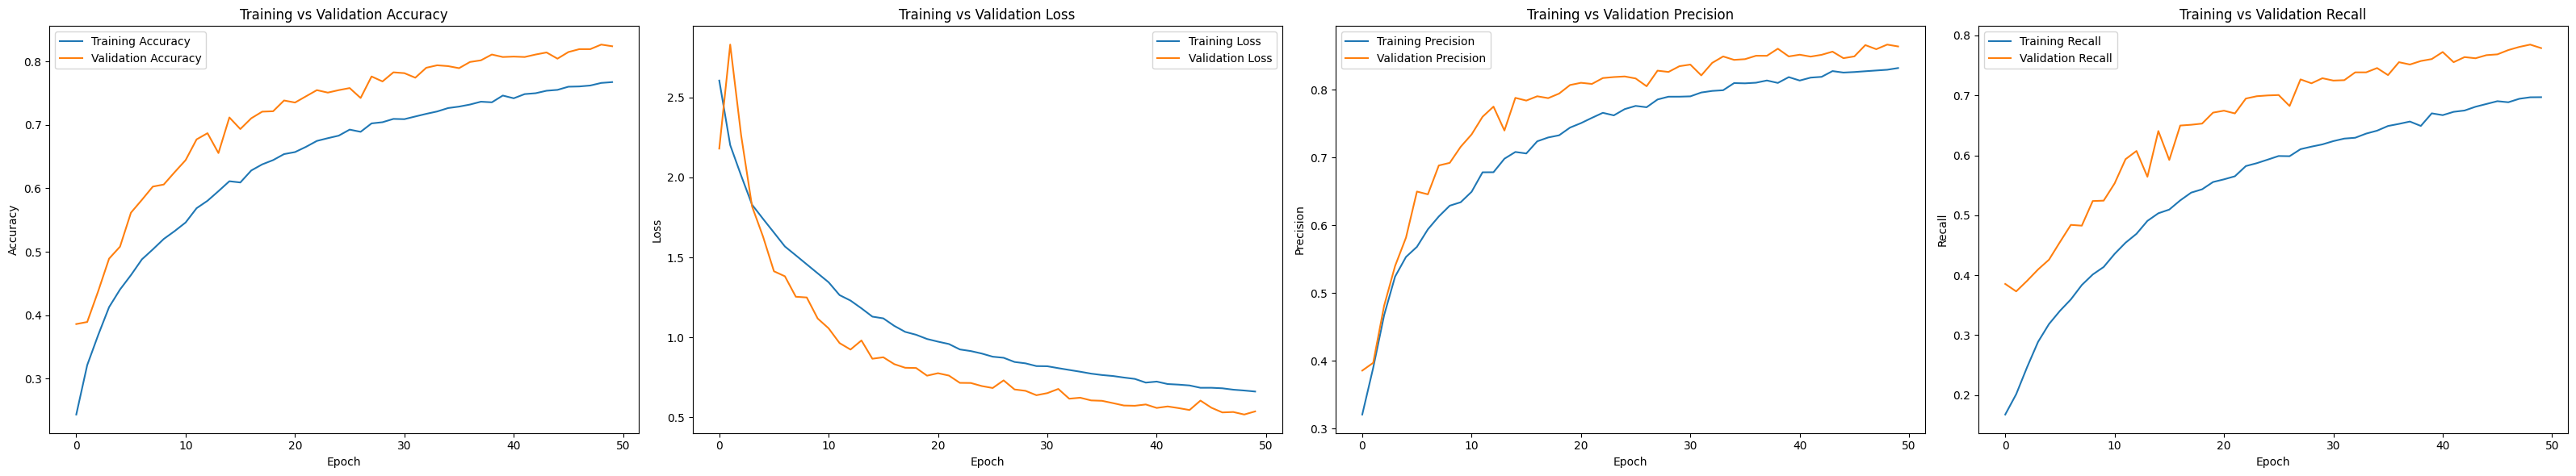

In [ ]:
evaluate(history_custom)

# Test

In [ ]:
def predict_label(model, image):
    num2label = {0: 'Surprise',
                 1: 'Fear',
                 2: 'Disgust',
                 3: 'Happy',
                 4: 'Sad',
                 5: 'Angry',
                 6: 'Neutral'}

    resized_image = cv2.resize(image, (target_image_size, target_image_size))
    res_image = np.expand_dims(resized_image, axis=0)

    res = model.predict(res_image)
    idx = np.argmax(res)
    label = num2label[idx]
    return label

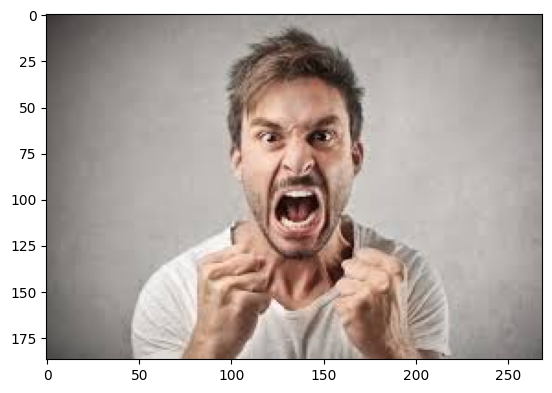

In [ ]:
test_img_dir = datadir + "angry_0.jpg"
test_img = cv2.imread(test_img_dir)
plt.imshow(test_img[:,:,[2,1,0]])

In [ ]:
predict_label(model_rn, test_img)

1/1 [==============================] - 0s 145ms/step


'Sad'

In [ ]:
predict_label(model_custom, test_img)

1/1 [==============================] - 1s 834ms/step


'Surprise'

First use face detection model to extract face image, then predict label

In [ ]:
def find_face_images(img):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  face_imgs = []

  # extract each face region
  for (x, y, w, h) in faces:
      face = img[y:y+h, x:x+w]
      face_imgs.append(face)

  return face_imgs

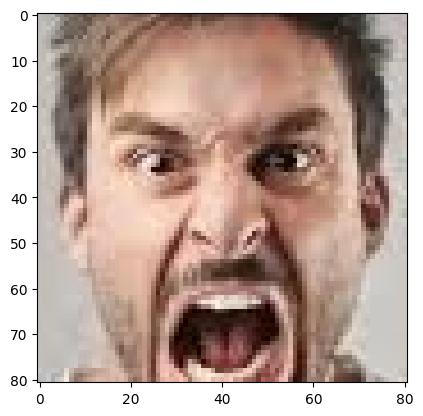

In [ ]:
face_imgs = find_face_images(test_img)
face_img = face_imgs[0]
plt.imshow(face_img[:,:,[2,1,0]])

In [ ]:
predict_label(model_rn, face_img)

1/1 [==============================] - 0s 100ms/step


'Sad'

In [ ]:
predict_label(model_custom, face_img)

1/1 [==============================] - 0s 99ms/step


'Surprise'